In [1]:
from keras.datasets import boston_housing

Using TensorFlow backend.


In [2]:
(train_data, train_target), (test_data, test_target) = boston_housing.load_data()

57344/57026 [==============================] - 0s 2us/step


In [3]:
# 404 training samples with 13 features
train_data.shape

(404, 13)

In [4]:
# 102 test samples with 13 features
test_data.shape

(102, 13)

In [7]:
# The targets are the median values of owner-occupied homes, in thousands of dollars
train_target

array([ 15.2,  42.3,  50. ,  21.1,  17.7,  18.5,  11.3,  15.6,  15.6,
        14.4,  12.1,  17.9,  23.1,  19.9,  15.7,   8.8,  50. ,  22.5,
        24.1,  27.5,  10.9,  30.8,  32.9,  24. ,  18.5,  13.3,  22.9,
        34.7,  16.6,  17.5,  22.3,  16.1,  14.9,  23.1,  34.9,  25. ,
        13.9,  13.1,  20.4,  20. ,  15.2,  24.7,  22.2,  16.7,  12.7,
        15.6,  18.4,  21. ,  30.1,  15.1,  18.7,   9.6,  31.5,  24.8,
        19.1,  22. ,  14.5,  11. ,  32. ,  29.4,  20.3,  24.4,  14.6,
        19.5,  14.1,  14.3,  15.6,  10.5,   6.3,  19.3,  19.3,  13.4,
        36.4,  17.8,  13.5,  16.5,   8.3,  14.3,  16. ,  13.4,  28.6,
        43.5,  20.2,  22. ,  23. ,  20.7,  12.5,  48.5,  14.6,  13.4,
        23.7,  50. ,  21.7,  39.8,  38.7,  22.2,  34.9,  22.5,  31.1,
        28.7,  46. ,  41.7,  21. ,  26.6,  15. ,  24.4,  13.3,  21.2,
        11.7,  21.7,  19.4,  50. ,  22.8,  19.7,  24.7,  36.2,  14.2,
        18.9,  18.3,  20.6,  24.6,  18.2,   8.7,  44. ,  10.4,  13.2,
        21.2,  37. ,

## Preparing Data

    - Each feature currently have wildly different ranges. This makes learning more difficult.
    - Best practice is to do feature-wise normalization: for each feature in the input data, subtract the mean of the feature and devided by the standard deviation, so that feature is centered around 0 and has a unit standard deviation.

In [8]:
# Normalizing data
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

# The quantity used for normalizing the test data must be computed from training data.
# Never use any quantity computed on the test data.
test_data -= mean
test_data /= std

In [17]:
from keras import models
from keras import layers

In [20]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1], )))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    # mae = mean absolute error. The absolute value of the difference between the predicted value and the target
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [21]:
# Since we have small amount of training data, use k-fold cross validation.
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epoch =100
all_scores = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_target[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0
    )
    partial_train_targets = np.concatenate(
        [train_target[:i * num_val_samples], train_target[(i + 1) * num_val_samples:]], axis=0
    )
    model = build_model()
    model.fit(partial_train_data, partial_train_targets, epochs=num_epoch, batch_size=1,verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)
    
    

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [22]:
print(all_scores)
print(np.mean(all_scores))

[1.9916030581634823, 2.4027165186287154, 2.5442428978362885, 2.5717689223808819]
2.37758284925


In [37]:
# Since we have small amount of training data, use k-fold cross validation.
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epoch = 500
batch_size = 1
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_target[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0
    )
    partial_train_targets = np.concatenate(
        [train_target[:i * num_val_samples], train_target[(i + 1) * num_val_samples:]], axis=0
    )
    model = build_model()
    history = model.fit(partial_train_data, 
                        partial_train_targets, 
                        validation_data=(val_data, val_targets), 
                        epochs=num_epoch, 
                        batch_size=batch_size,
                        verbose=0)
    mae_history = history.history['val_mean_absolute_error']

    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [38]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epoch)]

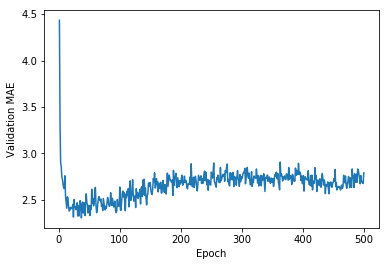

In [39]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epoch')
plt.ylabel('Validation MAE')
plt.show()

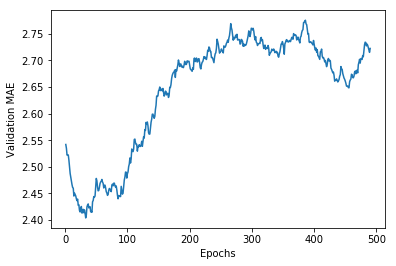

In [40]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()